# QAOA
1. Define a cost Hamiltonian $H_C$ such that its ground state encodes the solution to the optimization problem
2. Define a mixer Hamiltonian $H_M$
3. Construct the circuits $e^{-i \gamma H_M}$ and $e^{-i \alpha H_M}$. We call these the cost and mixer layers, respectively.
4. Choose a  parameter $n \ge 1$ and build the circuit $$ U(\gamma,\alpha) =  e^{-i \gamma H_M}e^{-i \alpha H_M} ... e^{-i \gamma H_M}e^{-i \alpha H_M},$$ consisting of repeated application of the cost and mixer layers.
5. Prepare an initial state, apply $U(\gamma,\alpha)$, and use classical techniques to optimize the parameters.
6. After the circuit has been optimized, measurements of the output state reveal approximate solutions to the optimization problem.

In [1]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

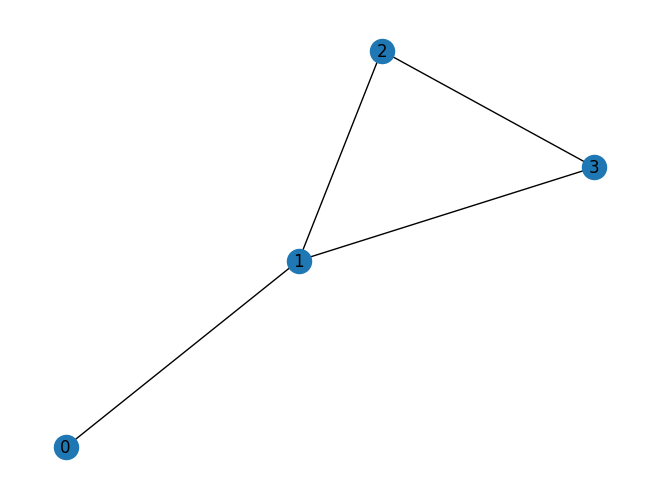

In [2]:
edges = [(0, 1), (1, 2), (1,3), (2,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [3]:
cost_h, mixer_h = qaoa.maxcut(graph)

print("Cost", cost_h)
print("Mixer", mixer_h)

Cost   (-2.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z1 Z2]
+ (0.5) [Z1 Z3]
+ (0.5) [Z2 Z3]
Mixer   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [4]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [5]:
wires = range(4)
depth = 2


def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [6]:
dev = qml.device("qulacs.simulator", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [7]:
optimizer = qml.GradientDescentOptimizer()
steps = 30
params = np.array([[0.5,0.5], [0.5,0.5]], requires_grad=True)

In [8]:
for i in range(steps):
    params = optimizer.step(cost_function,params)

print(params)

[[0.57933748 0.16132382]
 [0.54784663 0.76706825]]


In [9]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma,alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

In [10]:
#print(plt.style.available)

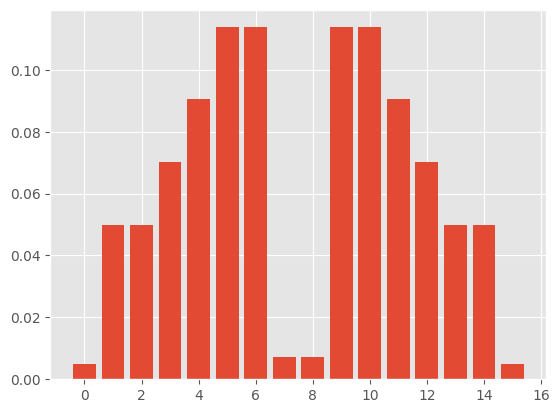

0: ──H─╭ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.58)
1: ──H─├ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.58)
2: ──H─├ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.58)
3: ──H─╰ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.58)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.55)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.55)
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.55)
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.55)

──╭ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.16)
──├ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.16)
──├ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.16)
──╰ApproxTimeEvolution(0.50,0.50,0.50,0.50,-2.00,0.16)

──╭ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.77)─┤  
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.77)─┤  
──├ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.77)─┤  
──╰ApproxTimeEvolution(1.00,1.00,1.00,1.00,0.77)─┤  


In [11]:
plt.style.use("ggplot")
plt.bar(range(2**len(wires)),probs)
plt.show()
print(qml.draw(circuit)([params[0],params[1]]))

In [12]:
wires = range(4)
depth = 2
@qml.transforms.to_zx
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [13]:
import pyzx as zx

dev = qml.device('default.qubit', wires = 4)

g = circuit(params)
print(g.depth())
zx.draw(g)
graph = zx.extract_simple(g).to_graph()
zx.settings.tikzit_location = "/usr/bin/tikzit"
zx.tikz.tikzit(graph)

29


Opening Tikzit...


Attribute Qt::AA_EnableHighDpiScaling must be set before QCoreApplication is created.
2


Done


In [14]:
zx.simplify.id_simp(graph)
zx.simplify.spider_simp(graph)
#zx.simplify.id_simp(g)
zx.simplify.interior_clifford_simp(graph)

id_simp: 20.  1 iterations
spider_simp: 6. 3. 2. 1.  4 iterations
spider_simp: 6. 1.  2 iterations
pivot_simp: 2. 2.  2 iterations


1

In [15]:
g.normalize()
zx.draw(graph)

In [16]:
res = zx.extract_circuit(graph.copy(), optimize_cnots=3).to_basic_gates()

In [17]:
zx.draw(res)

In [18]:
fr_graph = res.to_graph()
# Simple simplifications
zx.spider_simp(fr_graph,quiet=False)
zx.id_simp(fr_graph,quiet=False)
zx.to_rg(fr_graph)
#The simps above dont change the graph too much so we can use the extract_simple
fr_opt = zx.extract_simple(fr_graph)
print()
#print(fr_opt.stats(),)#"\nEQUAL: " , g.verify_equality(fr_opt))
zx.draw(fr_opt)

spider_simp: 16. 13. 9. 6. 4. 2. 2.  7 iterations
id_simp: 4.  1 iterations



In [19]:
fr_opt.depth()

30

In [ ]:
zx.settings.tikzit_location = "/usr/bin/tikzit"
zx.tikz.tikzit(fr_opt)

Opening Tikzit...


Attribute Qt::AA_EnableHighDpiScaling must be set before QCoreApplication is created.
2
